In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003686467, 'queue_time': 0.048933104, 'total_time': 0.053686467}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_92412bc7e4', 'finish_reason': 'stop', 'logprobs': None}, id='run-a40f1042-9888-4b22-9665-81330655e780-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [2]:
### State
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class State(TypedDict):
    user_input: str
    user_input_requirements: str
    user_stories: str
    po_review: str
    design_documents: str
    revised_user_stories: str
    design_review: str
    code: str
    code_review: str
    fixed_code: str
    security_review: str
    final_code: str
    test_cases: str
    test_cases_review: str
    final_test_cases: str
    qa_testing_report: str
    deployment_report: str
    monitoring_feedback: str
    maintenance_update: str
    pass

In [3]:
### Nodes Definition

def UserInputRequirements(state: State):
    """LLM Call to get the requirements for the user input"""

    print("LLM call 1: UserInputRequirements")
        # Use the LLM to generate requirements based on the user input
    prompt = f"Write a clear and concise description of the requirements for the following user input: {state['user_input']}"
    response = llm.invoke(prompt)
     # Extract the generated requirements from the LLM response
    requirements = response.content
    print(f"User Input Requirements: {requirements}")
    return {"user_input_requirements": requirements}

def AutoGenerateUserStories(state: State):
    """LLM Call to auto-generate user stories"""

    print("LLM call 2: AutoGenerateUserStories")
    # Use the LLM to generate user stories based on the user input and requirements
    prompt = f"Write user stories in the format 'As a [user], I want to [perform some task] so that [achieve some goal]' for the following user input and requirements: {state['user_input']}. Requirements: {state['user_input_requirements']}"
    response = llm.invoke(prompt)
    # Extract the generated user stories from the LLM response
    user_stories = response.content
    print(f"User Stories: {user_stories}")
    return {"user_stories": user_stories}


def ProdutOwnerReview(state: State):
    """Product Owner reviews the user stories"""

    print("LLM call 3: ProdutOwnerReview")
    # Product Owner reviews the user stories and provides feedback
    # user_stories = state["user_stories"]
    prompt = f"""Evaluate the following user stories against these criteria:
    1. Clear business value statement
    2. Proper acceptance criteria
    3. INVEST principle compliance
    4. Technical feasibility
    5. Scope appropriateness
    
    User Stories: {state['user_stories']}
    
    First, state either "Approved" or "Feedback" based on compliance with all criteria.
    Then provide brief rationale. Format: "[Decision] [Rationale]"
    
    Example approved: "Approved: All stories meet INVEST principles with clear acceptance criteria"
    Example feedback: "Feedback: Story 3 lacks measurable acceptance criteria"
    """
    response = llm.invoke(prompt)
    feedback = response.content
    print(f"Product Owner Review: {feedback}")
    # feedback = "The user stories are clear and concise. I approve them."
    return {"po_review": feedback}

def Check_ProdutOwnerReview(state: State):
    """Check if the Product Owner has approved the user stories"""

    print("LLM call 4: Check_ProdutOwnerReview")
    po_review = state["po_review"]
    # Check if the Product Owner has approved the user stories
    # Use a case-insensitive check for keywords indicating approval
    approval_keywords = ["approve", "approved", "accept", "accepted"]
    if any(keyword in po_review.lower() for keyword in approval_keywords):
        print("Product Owner Review: Approved")
        return "Approved"
    else:
        print("Product Owner Review: Feedback")
        return "Feedback"

def DesignDocuments(state: State):
    """Create Design Docuemnents - Functional and technical"""

    print("LLM call 5: DesignDocuments")
    # Create design documents based on the user stories
    # user_stories = state["user_stories"]
    prompt = f"Create detailed functional and technical design documents for the following approved user stories: {state['user_stories']}. Ensure the documents include system architecture, data flow, and key technical specifications. Make sure that user stories to consider here should be approved by the Product Owner."
    response = llm.invoke(prompt)
    design_documents = response.content
    print(f"Design Documents: {design_documents}")
    return {"design_documents": design_documents}

def ReviseUserStories(state: State):
    """Revise user stories based on the Feedback from the Product Owner Review"""

    print("LLM call 6: ReviseUserStories")
    feedback = state["po_review"]
    # user_stories = state["user_stories"]
    prompt = f"Revise the following user stories based on the feedback provided by the Product Owner: {state['user_stories']}. Feedback: {feedback}"
    response = llm.invoke(prompt)
    revised_user_stories = response.content
    print(f"Revised User Stories: {revised_user_stories}")
    return {"revised_user_stories": revised_user_stories}

def DesignReview(state: State):
    """Review of the Design Documents by the Product Owner"""

    print("LLM call 7: DesignReview")
    design_documents = state["design_documents"]
    prompt = f"Review the following design documents : {design_documents} and provide feedback whether it meets the requirements accordingly it will be Approved or it needs some changes i.e Feedback"
    response = llm.invoke(prompt)
    feedback = response.content
    print(f"Design Review: {feedback}")
    return {"design_review": feedback}


def Check_DesignReview(state: State):
    """Do the check of the Design Review"""

    print("LLM call 8: Check_DesignReview")
    design_review = state["design_review"]
    # Check if the Product Owner has approved the design documents
    # Use a case-insensitive check for keywords indicating approval
    approval_keywords = ["approve", "approved", "accept", "accepted"]
    if any(keyword in design_review.lower() for keyword in approval_keywords):
        print("Design Review: Approved")
        return "Approved"
    else:
        print("Design Review: Feedback")
        return "Feedback"
    
def GenerateCode(state: State):
    """Generates and self-assesses code against quality criteria"""
    
    print("LLM call 9: GenerateCode")
    
    quality_criteria = """Code must satisfy ALL of these:
    1. Implements all design requirements
    2. Contains proper error handling
    3. Follows language-specific best practices
    4. Includes documentation/comments
    5. Passes basic smell checks (DRY, SOLID)"""
    
    prompt = f"""Generate code based on these design documents:
    {state['design_documents']}
    {state['design_review']}
    
    Follow this process:
    1. Generate implementation code
    2. Review against criteria: {quality_criteria}
    3. If ALL met: Start with "APPROVED: "
       Else: Start with "FEEDBACK: "
    4. Provide code after ===CODE=== separator
    
    Example APPROVED:
    APPROVED: Fully implements design with error handling
    ===CODE===
    // Sample code...
    
    Example FEEDBACK:
    FEEDBACK: Missing null checks in payment processor
    ===CODE===
    // Partial implementation...
    """
    response = llm.invoke(prompt)
    code = response.content
    print(f"Generated Code: {code}")
    return {"code": code}

def CodeReview(state: State):
    """Review the generated code"""

    print("LLM call 10: CodeReview")
    code = state["code"]
    prompt = f"Review the following code and provide feedback whether it meets the requirements accordingly it will be Approved or it needs some changes i.e Feedback: {code}"
    response = llm.invoke(prompt)
    feedback = response.content
    print(f"Code Review: {feedback}")
    return {"code_review": feedback}

def Check_CodeReview(state: State):
    """Check the Code Review"""

    print("LLM call 11: Check_CodeReview")
    code_review = state["code_review"]
    # Check if the generated code has been approved
    # Use a case-insensitive check for keywords indicating approval
    approval_keywords = ["approve", "approved", "accept", "accepted"]
    if any(keyword in code_review.lower() for keyword in approval_keywords):
        print("Code Review: Approved")
        return "Approved"
    else:
        print("Code Review: Feedback")
        return "Feedback"
    
def FixCode(state: State):
    """Fix the code based on the feedback from the code review"""

    print("LLM call 12: FixCode")
    feedback = state["code_review"]
    code = state["code"]
    prompt = f"Revise the following code based on the feedback provided in the code review: {code}. Feedback: {feedback}"
    response = llm.invoke(prompt)
    fixed_code = response.content
    print(f"Fixed Code: {fixed_code}")
    return {"fixed_code": fixed_code}

def SecurityReview(state: State):
    """Security review of the code"""

    print("LLM call 13: SecurityReview")
    code = state["code"]
    prompt = f"Perform a security review of the following code and provide feedback on potential vulnerabilities and improvements whether it meets the requirements accordingly it will be Approved or it needs some changes i.e Feedback: {code}"
    response = llm.invoke(prompt)
    security_feedback = response.content
    print(f"Security Review: {security_feedback}")
    return {"security_review": security_feedback}

def Check_SecurityReview(state: State):
    """Check the Security Review"""

    print("LLM call 14: Check_SecurityReview")
    security_review = state["security_review"]
    # Check if the code has passed the security review
    # Use a case-insensitive check for keywords indicating approval
    approval_keywords = ["approve", "approved", "accept", "accepted"]
    if any(keyword in security_review.lower() for keyword in approval_keywords):
        print("Security Review: Approved")
        return "Approved"
    else:
        print("Security Review: Feedback")
        return "Feedback"
    
def FixCodeSecurity(state: State):
    """Fix the code based on the feedback from the security review"""

    print("LLM call 15: FixCodeSecurity")
    security_feedback = state["security_review"]
    code = state["code"]
    prompt = f"Revise the following code based on the feedback provided in the security review: {code}. Feedback: {security_feedback}"
    response = llm.invoke(prompt)
    final_code = response.content
    print(f"FixCodeSecurity: {final_code}")
    return {"final_code": final_code}

def WriteTestCases(state: State):
    """Generate test cases for the final code"""

    print("LLM call 16: WriteTestCases")
    code = state["code"]
    prompt = f"Generate test cases for the following code: {code}. Ensure the test cases cover all possible scenarios and edge cases."
    response = llm.invoke(prompt)
    test_cases = response.content
    print(f"Test Cases: {test_cases}")
    return {"test_cases": test_cases}

def TestCasesReview(state: State):
    """Review the generated test cases"""

    print("LLM call 17: TestCasesReview")
    test_cases = state["test_cases"]
    prompt = f"Review the following test cases and provide feedback whether it meets the requirements accordingly it will be Approved or it needs some changes i.e Feedback: {test_cases}"
    response = llm.invoke(prompt)
    feedback = response.content
    print(f"Test Cases Review: {feedback}")    
    return {"test_cases_review": feedback}

def Check_TestCasesReview(state: State):
    """Check the Test Cases Review"""

    print("LLM call 18: Check_TestCasesReview")
    test_cases_review = state["test_cases_review"]
    # Check if the test cases have been approved
    # Use a case-insensitive check for keywords indicating approval
    approval_keywords = ["approve", "approved", "accept", "accepted"]
    if any(keyword in test_cases_review.lower() for keyword in approval_keywords):
        print("Test Cases Review: Approved")
        return "Approved"
    else:
        print("Test Cases Review: Feedback")
        return "Feedback"
    
def FixTestCases(state: State):
    """Fix the test cases based on the feedback from the test cases review"""

    print("LLM call 19: FixTestCases")
    feedback = state["test_cases_review"]
    test_cases = state["test_cases"]
    prompt = f"Revise the following test cases based on the feedback provided in the test cases review: {test_cases}. Feedback: {feedback}"
    response = llm.invoke(prompt)
    final_test_cases = response.content
    print(f"Final Test Cases: {final_test_cases}")
    return {"final_test_cases": final_test_cases}

def QATesting(state: State):
    """Perform QA testing using the final test cases"""

    print("LLM call 20: QATesting")
    final_test_cases = state["test_cases"]
    prompt = f"Perform QA testing using the following test cases: {final_test_cases}. Report any bugs or issues found during testing, accordingly it will be Approved or it needs some changes i.e Feedback."
    response = llm.invoke(prompt)
    qa_testing_report = response.content
    print(f"QA Testing Report: {qa_testing_report}")    
    return {"qa_testing_report": qa_testing_report}

def Check_QATesting(state: State):
    """Check the QA testing report"""

    print("LLM call 21: Check_QATesting")
    qa_testing_report = state["qa_testing_report"]
    # Check if the QA testing report indicates any issues
    # Use a case-insensitive check for keywords indicating approval
    approval_keywords = ["approve", "approved", "accept", "accepted"]
    if any(keyword in qa_testing_report.lower() for keyword in approval_keywords):
        print("QA Testing Report: Passed")
        return "Passed"
    else:
        print("QA Testing Report: Failed")
        return "Failed"

def FixCodeAfterQA(state: State):
    """Fix the code based on the feedback from the QA testing report"""

    print("LLM call 22: FixCodeAfterQA")
    qa_testing_report = state["qa_testing_report"]
    final_code_1 = state["code"]
    prompt = f"Revise the following code based on the feedback provided in the QA testing report: {final_code_1}. Feedback: {qa_testing_report}"
    response = llm.invoke(prompt)
    fixed_code_after_qa = response.content
    print(f"Fixed Code After QA: {fixed_code_after_qa}")
    return {"fixed_code_after_qa": fixed_code_after_qa}

def Deploy(state: State):
    """Deploy the final code"""

    print("LLM call 23: Deploy")
    final_code = state["code"]
    prompt = f"Deploy the following code: {final_code}. Ensure the deployment is successful and report any issues encountered during the deployment process."
    response = llm.invoke(prompt)
    deployment_report = response.content
    print(f"Deployment Report: {deployment_report}")
    return {"deployment_report": deployment_report}

def  MonitorFeedback(state: State):
    """Monitor the deployed code for feedback"""

    print("LLM call 24: MonitorFeedback")
    deployment_report = state["deployment_report"]
    prompt = f"Monitor the deployed code and provide feedback on its performance and any issues encountered. Report any bugs or issues found during monitoring."
    response = llm.invoke(prompt)
    monitoring_feedback = response.content
    print(f"Monitoring Feedback: {monitoring_feedback}")
    return {"monitoring_feedback": monitoring_feedback}

def MaintenanceUpdate(state: State):
    """Perform maintenance and updates based on the monitoring feedback"""

    print("LLM call 25: MaintenanceUpdate")
    monitoring_feedback = state["monitoring_feedback"]
    prompt = f"Perform maintenance and updates based on the following monitoring feedback: {monitoring_feedback}. Ensure the code is up-to-date and any issues are resolved."
    response = llm.invoke(prompt)
    maintenance_update = response.content
    print(f"Maintenance Update: {maintenance_update}")
    print("------------------END------------------")
    return {"maintenance_update": maintenance_update}


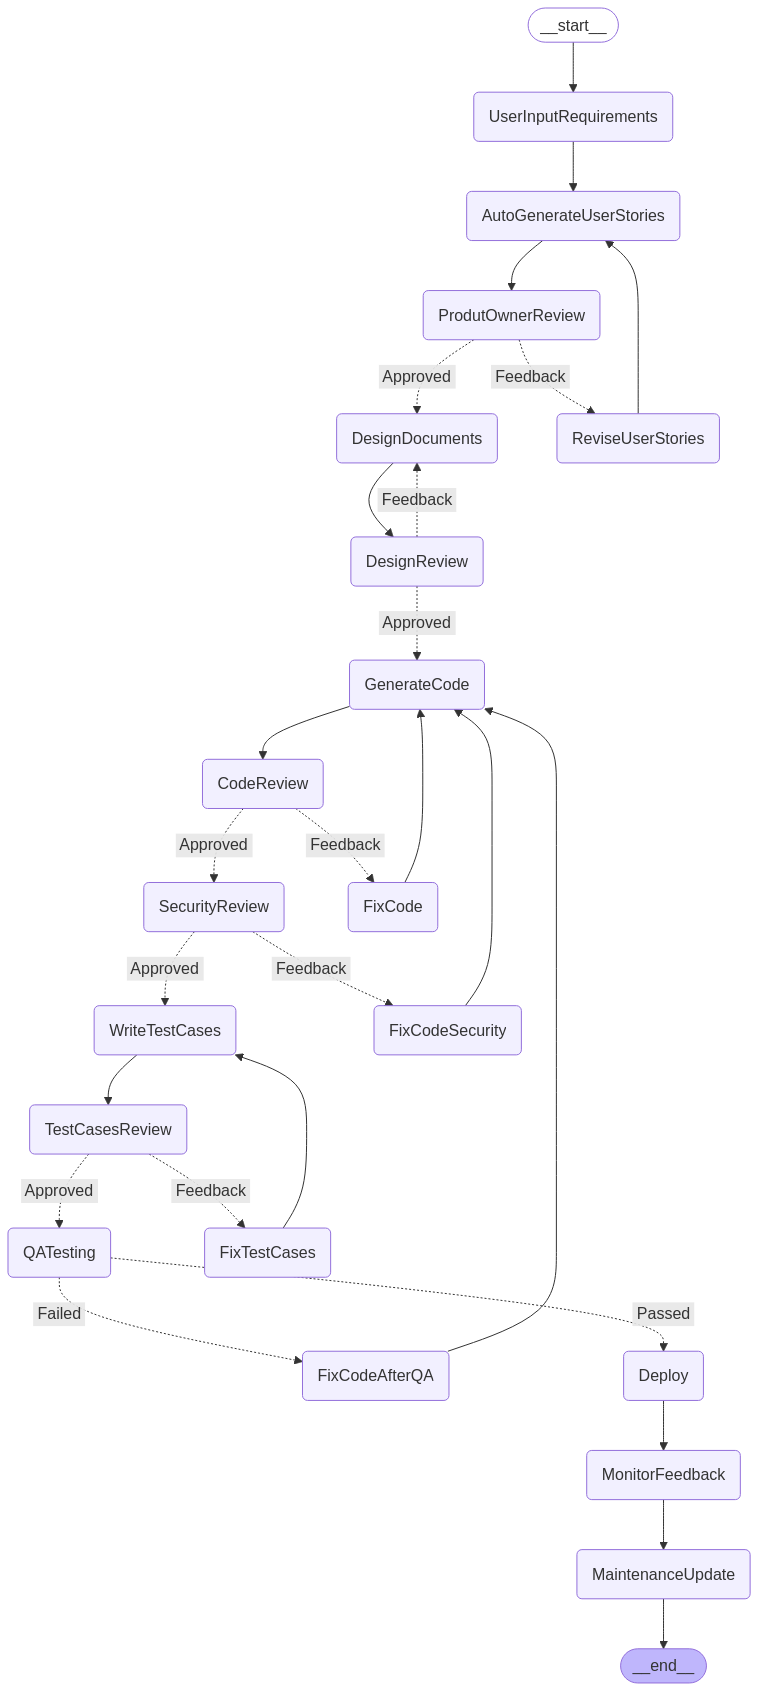

In [4]:
# Build Worklow

workflow = StateGraph(State)

# Add Nodes
workflow.add_node("UserInputRequirements", UserInputRequirements)
workflow.add_node("AutoGenerateUserStories", AutoGenerateUserStories)
# workflow.add_node("ProdonutOwnerReview", Check_ProdutOwnerReview, {"Approved":"DesignDocuments", "Feedback":"ReviseUserStories"})
workflow.add_node("ProdutOwnerReview", ProdutOwnerReview)
workflow.add_node("DesignDocuments", DesignDocuments)
workflow.add_node("ReviseUserStories", ReviseUserStories)
workflow.add_node("DesignReview", DesignReview)
workflow.add_node("GenerateCode", GenerateCode)
workflow.add_node("CodeReview", CodeReview)
workflow.add_node("SecurityReview", SecurityReview)
workflow.add_node("FixCode", FixCode)
workflow.add_node("WriteTestCases", WriteTestCases)
workflow.add_node("FixCodeSecurity", FixCodeSecurity)
workflow.add_node("TestCasesReview", TestCasesReview)
workflow.add_node("QATesting", QATesting)
workflow.add_node("FixTestCases", FixTestCases)
workflow.add_node("FixCodeAfterQA", FixCodeAfterQA)
workflow.add_node("Deploy", Deploy)
workflow.add_node("MonitorFeedback", MonitorFeedback)
workflow.add_node("MaintenanceUpdate", MaintenanceUpdate)


# Add Edges
workflow.add_edge(START, "UserInputRequirements")
workflow.add_edge("UserInputRequirements", "AutoGenerateUserStories")
workflow.add_edge("AutoGenerateUserStories", "ProdutOwnerReview")
workflow.add_conditional_edges("ProdutOwnerReview", Check_ProdutOwnerReview, {"Approved":"DesignDocuments", "Feedback":"ReviseUserStories"})
workflow.add_edge("ReviseUserStories", "AutoGenerateUserStories")
workflow.add_edge("DesignDocuments", "DesignReview")
workflow.add_conditional_edges("DesignReview", Check_DesignReview, {"Approved":"GenerateCode", "Feedback":"DesignDocuments"})
workflow.add_edge("GenerateCode", "CodeReview")
workflow.add_conditional_edges("CodeReview", Check_CodeReview, {"Approved":"SecurityReview", "Feedback":"FixCode"})
workflow.add_edge("FixCode", "GenerateCode")
workflow.add_conditional_edges("SecurityReview", Check_SecurityReview, {"Approved":"WriteTestCases", "Feedback":"FixCodeSecurity"})
workflow.add_edge("FixCodeSecurity", "GenerateCode")
workflow.add_edge("WriteTestCases", "TestCasesReview")
workflow.add_conditional_edges("TestCasesReview", Check_TestCasesReview, {"Approved":"QATesting", "Feedback":"FixTestCases"})
workflow.add_edge("FixTestCases", "WriteTestCases")
workflow.add_conditional_edges("QATesting", Check_QATesting, {"Passed":"Deploy", "Failed":"FixCodeAfterQA"})
workflow.add_edge("FixCodeAfterQA", "GenerateCode")
workflow.add_edge("Deploy", "MonitorFeedback")
workflow.add_edge("MonitorFeedback", "MaintenanceUpdate")
workflow.add_edge("MaintenanceUpdate", END)

# Compile Workflow
graph = workflow.compile()

# Show workflow
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
response = graph.invoke({
    "user_input": "I want to create a web application that allows users to track their fitness goals."
},{"recursion_limit": 500})
print(response)

LLM call 1: UserInputRequirements
User Input Requirements: To create a web application that allows users to track their fitness goals, the following requirements should be considered:

1. **User Registration and Login**: Users should be able to create an account and log in using their email and password or through social media accounts.

2. **Goal Setting**: Users should be able to set specific fitness goals, such as weight loss, muscle gain, or specific performance targets (e.g., running a 5K).

3. **Progress Tracking**: The application should allow users to log their daily activities, such as the type of workout, duration, intensity, and calories burned. It should also track changes in body measurements, weight, and other relevant metrics.

4. **Nutrition Tracking**: Include a feature to track daily food intake and nutritional values, which can be input manually or by scanning barcodes.

5. **Interactive Interface**: The interface must be user-friendly, allowing for easy navigation a